# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## X. Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

The basis of this project are three datasets: portifolio.json, profile.json and transcript.json. 

The portfolio dataset includes general offer-information such as which channel was used to communicate with potential customers (email, mobile, social), the difficulty which represents the amount of money a customer must spend in order to receive a discount, the duration of the offer, an unique offer id, the offer type and finally the reward itself.

The profile data set provieds detailed customer data such as age, gender, income and the date, an account was created via the Starbucks app.

The transcript data set lists purchases and detailed information about when and if an offer was completed or not. An offer can be regarded as successfull, once a customer both views an offer an reaches its difficulty within the odder's duration.

In the following, I am going to build a model that predicts if a customer will respond to an offer or not based on the information provided in the data sets. I will approach this issue in several steps: First I want to get a general understanding of the data sets. The Data Understanding section (1) will be used to understand and get to know the provided data. Second, I will be clean and combine the data sets as basis for a machine learing model (2).  In order to prepare and clean the data, categorical variables must be replaced by dummy variables, numercial features must be normalized, NaNs must be eliminated and the offer_id must be cleaned (transcipt data set) in order to identify a key value to merge the data frames. Once all data is cleaned, the data sets can be combined. As a consequence, each row of the new data set will provide information of the offer itself, the related customer and whether or not the offer was successful or not.

Finally, I will build a model that predicts if a customer will respond to an offer or not. I will do so by computing the accuracy and the F1-Score of a naive model as a benchmark. The accuracy measures how well the model predicts an offer is successfull or not. The F1 score can be interpreted as a weighted average of the precision and recall, where a F1 score reaches its best value at 1 and worst score at 0.  This model will be used as a benachmark for the other model I will cosntruct. 

## 0. Import all needed packages and libraries

In [1]:
import re
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Understanding

### Portfolio Dataset

In [2]:
# show dataset
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
# looking for null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [4]:
# get shape
portfolio.shape

(10, 6)

Text(0,0.5,'Amount')

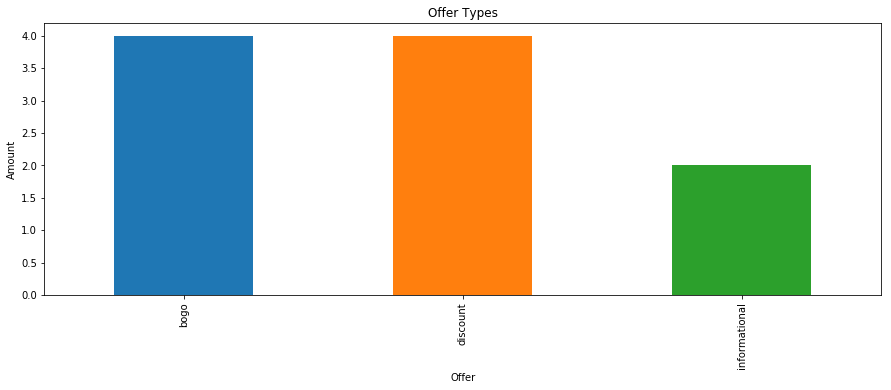

In [5]:
# visualisiation of different offer types
graph_portfolio = portfolio["offer_type"].value_counts().plot.bar(figsize=(15,5))

graph_portfolio.set_title("Offer Types")
graph_portfolio.set_xlabel("Offer")
graph_portfolio.set_ylabel("Amount")

#### Findings
As expected, the portfolio dataframe is clean. There are no missing values. The shape of the data frame is (10,6). 

Data preparation:

- Transofrm the channels column and seperate the entries to single, binary columns
- Prepare date for ML

### Profile Dataset

In [6]:
# show dataset
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.shape

(17000, 5)

In [8]:
# looking for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [9]:
# get shape
profile.shape

(17000, 5)

In [10]:
# analyze entries with NaNs
profile[profile.isna().any(axis=1)]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


Text(0,0.5,'Amount')

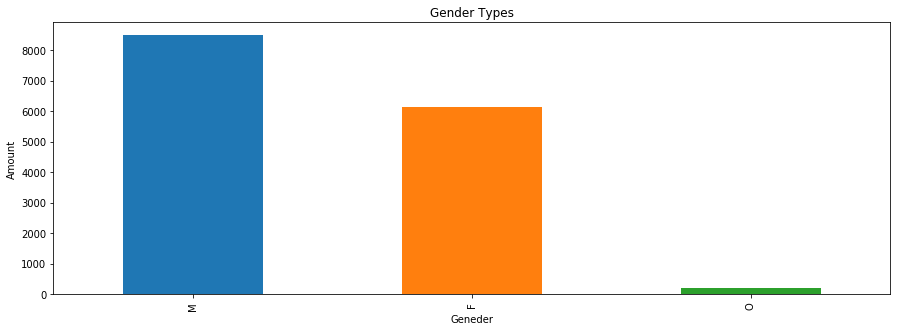

In [11]:
# visualize and understand profile dataset

# focus on gender
profile_gender = profile["gender"].value_counts().plot.bar(figsize=(15,5))

profile_gender.set_title("Gender Types")
profile_gender.set_xlabel("Geneder")
profile_gender.set_ylabel("Amount")


Text(0,0.5,'Count')

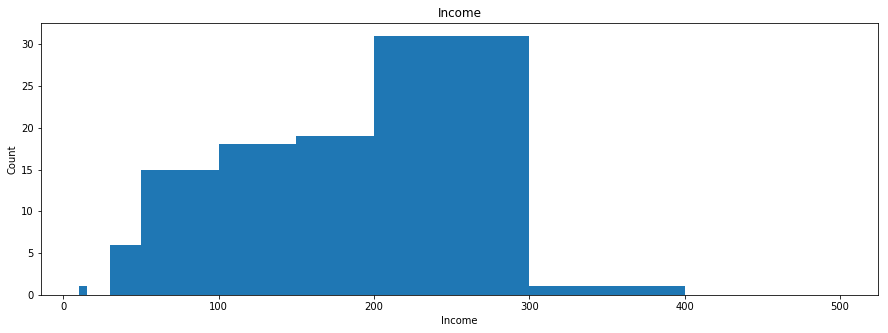

In [12]:
# focus on income
profile_income = profile["income"].value_counts().plot.hist(bins=[10,15,20, 30, 50, 100, 150, 200, 300, 400, 500], figsize=(15,5))

profile_income.set_title("Income")
profile_income.set_xlabel("Income")
profile_income.set_ylabel("Count")

Text(0,0.5,'Count')

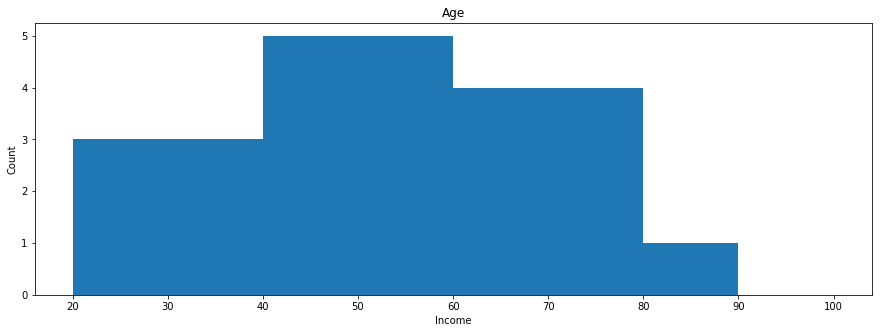

In [13]:
# focus on age
profile_age = profile["age"].value_counts().plot.hist(bins=[20,40,60,80,90,100], figsize=(15,5))

profile_age.set_title("Age")
profile_age.set_xlabel("Income")
profile_age.set_ylabel("Count")

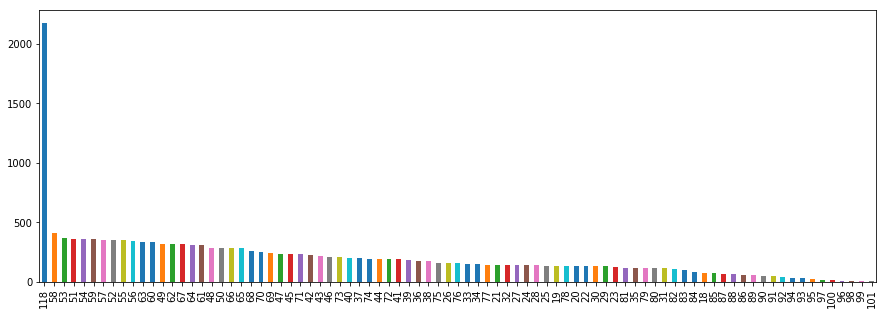

In [14]:
# focus on age
profile["age"].value_counts().plot(kind='bar', figsize=(15,5))

Data points with a vale in the age column of 118 can be regarded as outliers!

#### Findings
The profile data set has a shape of (17000, 5). The data set contains 2175 NaNs (missing values) which all show the same pattern. There are no gender and income related information. 

All of the NaN entries also represend outliers as they show an age of 118 (which does not make sense as a Starbucks Customer)

Data preparation:
 
- Convert became_member_on column to datetime 
- Delete all rows with NANs as these can not be used for ML
- Prepare data for ML

## Transcript Dataset

In [15]:
# show data set
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [16]:
# shape
transcript.shape

(306534, 4)

In [17]:
# check for NaNs
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

#### Findings
The transcript data set has a shape of (306534, 4). This menas, that more than 300.000 transactions were recorded. The data set contains no NaNs. 

Data preparation:
 
- Convert became_member_on column to datetime 
- Delete all rows with NANs as these can not be used for ML
- Prepare data for ML

## 2. Data Cleaning

In this section I will be clean and combine the data sets as basis for a machine learing model. In order to prepare and clean the data, categorical variables must be replaced by dummy variables, numercial features must be normalized, NaNs must be eliminated and the offer_id must be cleaned (transcipt data set) in order to identify a key value to merge the data frames. Once all data is cleaned, the data sets can be combined. As a consequence, each row of the new data set will provide information of the offer itself, the related customer and whether or not the offer was successful or not.

As I will be using a random forest calssifier as basis of a machine learning model, it is important to remove all NANs. Typically, random forest methods encourage two ways of handling missing values: a) drop data points with missing values or b) fill in missing values with the median (for numerical values) or mode (for categorical values). As all data points that have a Nan in the income column are related to persons with an age of 118, this data seems useless as basis for further analysis. Consequently, this data will be eliminated out of the dataset.

https://medium.com/airbnb-engineering/overcoming-missing-values-in-a-random-forest-classifier-7b1fc1fc03ba

### Portfolio Dataset
Encode categorical features as a one-hot numeric array

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html and
https://stackoverflow.com/questions/6986986/bin-size-in-matplotlib-histogram

In [18]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [19]:
def prepare_portfolio (df = portfolio):
    '''
    Args:
    df: Data Frame. Data Frame containg information such as channel, diffuculty, duration, id ,offer_type and reward
       
    Returns:
    df: Data Frame. One hot encoded data frame
    
    '''
    
    # get dummies for channels column
    channels = portfolio['channels'].str.join(sep=',').str.get_dummies(sep=',')
    
    # get dummies for offer_type
    offer = pd.get_dummies(portfolio['offer_type'])
    
    # concat original portfolio df with hot encoded channels and offer df
    portfolio_edit = pd.concat([df, channels, offer], axis = 1, sort = False)
    
    # rename id column  to offer_id.
    portfolio_edit.rename(columns={'id': 'offer_id'}, inplace=True)
    
    # Drop columns channel and offer_type
    portfolio_edit = portfolio_edit.drop(['channels', 'offer_type'], axis=1)

    
    
    return portfolio_edit

In [20]:
portfolio_edit = prepare_portfolio(portfolio)

In [21]:
portfolio_edit.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


### Profile Data Set

In [22]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [23]:
def prepare_profile (df = profile):
    '''
    Args:
    df: Data Frame. Data Frame containg information such as age, became_member_on, gender, id and income
       
    Returns:
    df: Data Frame. Encoded categorical features as a one-hot numeric array
    
    '''
    profile_edit = profile
    
    # Rename id column to customer_id
    profile_edit.rename(columns={'id': 'customer_id'}, inplace=True)
  
    # Clean beacame_member_on column by converting coulumn with datetime
    profile_edit.became_member_on = profile_edit['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")
    
    # Seperate became_member_on column to year and month
    profile_edit["year"] = profile_edit.became_member_on.dt.year
    profile_edit["month"] = profile_edit.became_member_on.dt.month
    
    # Get dummies for geneder
    gender = pd.get_dummies(profile_edit['gender'])
    
    # concat original profile df with hot encoded df
    profile_edit = pd.concat([df, gender], axis = 1, sort = False)
    
    # Drop columns age, gender, became_member_on and income
    profile_edit = profile_edit.drop(['gender'], axis=1)
    
    return profile_edit

In [24]:
profile_edit = prepare_profile(profile)

In [25]:
# Check for NaNs
profile_edit.isnull().sum()
  
# Drop Rows with  NaNs in income
profile_edit = profile_edit.drop(profile_edit[profile_edit['income'].isnull()].index)

In [26]:
profile_edit.head()

,age,became_member_on,customer_id,income,year,month,F,M,O
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,1,0,0
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,1,0,0
5,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,0,1,0
8,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,0,1,0
12,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,0,1,0


In [27]:
# Check for NaNs
profile_edit.isnull().sum()

age                 0
became_member_on    0
customer_id         0
income              0
year                0
month               0
F                   0
M                   0
O                   0
dtype: int64

### Transcript Data Set

In [28]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [29]:
# Find keys in value column 
values = set()
for i in transcript.value:
    values.update(set(i.keys()))

values

{'amount', 'offer id', 'offer_id', 'reward'}

In [30]:
def get_offer_id(dict_val):
    
    """
    Args:
    dict_val: dictionary. Dictionary from transcript['value'] column
    
    OUTPUT:
    value_offer_id: object. - value of the offer_id or offer id column
    """
    
    for i in ["offer_id", "offer id"]:
        if i in dict_val:
            value_offer_id = dict_val[i]
            break
    else:
        value_offer_id = np.nan
    
    return value_offer_id

def prepare_transcript(transcript):
    
    '''
    Args:
    df: Data Frame. Trascript Data Frame
       
    Returns:
    df: Data Frame. trasctipt_edit with seperated offer_id
    
    '''
    
    # Create offer_id column
    transcript["offer_id"] = transcript['value'].apply(get_offer_id)
    
    # Get dummies for event column
    event = pd.get_dummies(transcript['event'])
    
    # Concat original trascipt df with hot encoded df
    transcript_edit = pd.concat([transcript, event], axis=1, sort=False)
    
    # Drop value, transaction and event column
    transcript_edit = transcript_edit.drop(['value', 'transaction', 'event'], axis=1)
    
    # Rename offer completed, offer received, offer viewed and person
    transcript_edit.rename(columns={'offer completed': 'offer_completed'}, inplace=True)
    transcript_edit.rename(columns={'offer received': 'offer_received'}, inplace=True)
    transcript_edit.rename(columns={'offer viewed': 'offer_viewed'}, inplace=True)
    transcript_edit.rename(columns={'person': 'customer_id'}, inplace=True)
    
    
    
    return transcript_edit

In [31]:
transcript_edit = prepare_transcript(transcript)
transcript_edit.head()

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


## 3. Data Exploration

In [32]:
portfolio_edit.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


In [33]:
profile_edit.head()

,age,became_member_on,customer_id,income,year,month,F,M,O
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,1,0,0
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,1,0,0
5,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,0,1,0
8,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,0,1,0
12,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,0,1,0


In [34]:
transcript_edit.head()

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


#### Merge all data sets to df_total

To get a data set that provides all the information needes for a machine learning model, the cleaned transcript data set, portfolio data set and profile data set will be merged in the following. Additionally, some general analysis will be made in order to better understand the structure of the data set an get an idea of the data's distribution.

In [35]:
# Merge profile_edit, trascript_edit and portfilio_edit to df_total
# Merge portfolio_edit and transcript_edit
df_total = transcript_edit.merge(portfolio_edit[portfolio_edit.columns])
df_total.head()
# Merge profile_edit with df_total
df_total = df_total.merge(profile_edit[profile_edit.columns])

In [36]:
df_total.head()

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed,difficulty,duration,reward,email,...,discount,informational,age,became_member_on,income,year,month,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,5,5,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,5,5,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0


In [37]:
df_total

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed,difficulty,duration,reward,email,...,discount,informational,age,became_member_on,income,year,month,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,5,5,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,5,5,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
5,78afa995795e4d85b5d9ceeca43f5fef,582,f19421c1d4aa40978ebb69ca19b0e20d,0,0,1,5,5,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
6,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0,10,7,10,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
7,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,10,7,10,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
8,78afa995795e4d85b5d9ceeca43f5fef,510,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,10,7,10,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
9,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,1,0,0,3,0,1,...,0,1,75,2017-05-09,100000.0,2017,5,1,0,0


In [38]:
# Final check
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 24 columns):
customer_id         148805 non-null object
time                148805 non-null int64
offer_id            148805 non-null object
offer_completed     148805 non-null uint8
offer_received      148805 non-null uint8
offer_viewed        148805 non-null uint8
difficulty          148805 non-null int64
duration            148805 non-null int64
reward              148805 non-null int64
email               148805 non-null int64
mobile              148805 non-null int64
social              148805 non-null int64
web                 148805 non-null int64
bogo                148805 non-null uint8
discount            148805 non-null uint8
informational       148805 non-null uint8
age                 148805 non-null int64
became_member_on    148805 non-null datetime64[ns]
income              148805 non-null float64
year                148805 non-null int64
month               148805 non-null 

In [39]:
df_total.offer_completed.value_counts()

0    116361
1     32444
Name: offer_completed, dtype: int64

### Analyze offer usage by user groups

In [40]:
# General style
sns.set_style('darkgrid')

Text(0,0.5,'Amount')

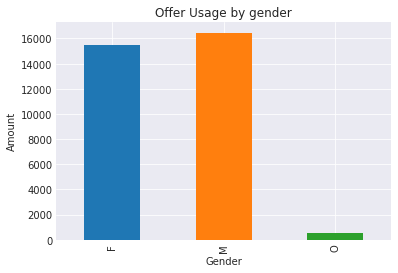

In [41]:
# Analysis by gender
gender_dist = df_total[df_total['offer_completed']==1][['F','M','O']].sum().plot.bar(fontsize=10) 
gender_dist.set_title("Offer Usage by gender")
gender_dist.set_xlabel("Gender")
gender_dist.set_ylabel("Amount")

Text(0,0.5,'Amount')

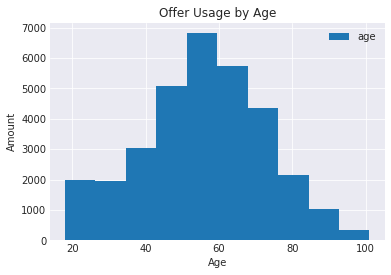

In [42]:
# Analysis by age
age_dist = df_total[df_total['offer_completed']==1][['age']].plot.hist(fontsize=10) 
age_dist.set_title("Offer Usage by Age")
age_dist.set_xlabel("Age")
age_dist.set_ylabel("Amount")

Text(0,0.5,'Amount')

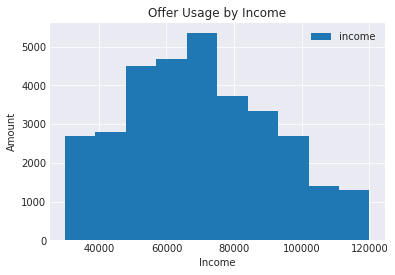

In [43]:
# Analysis by income
income_dist = df_total[df_total['offer_completed']==1][['income']].plot.hist(fontsize=10) 
income_dist.set_title("Offer Usage by Income")
income_dist.set_xlabel("Income")
income_dist.set_ylabel("Amount")

Text(0,0.5,'Amount')

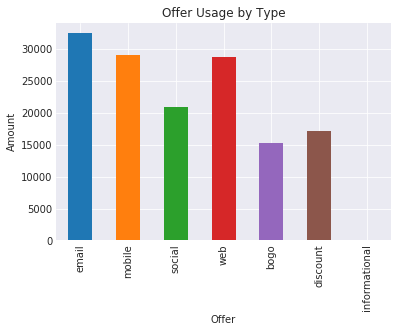

In [44]:
# Analysis by offer type
type_columns = ['email', 'mobile','social','web','bogo','discount','informational']
type_dist = df_total[df_total['offer_completed']==1][type_columns].sum().plot.bar(fontsize=10) 
type_dist.set_title("Offer Usage by Type")
type_dist.set_xlabel("Offer")
type_dist.set_ylabel("Amount")

Text(0,0.5,'Amount')

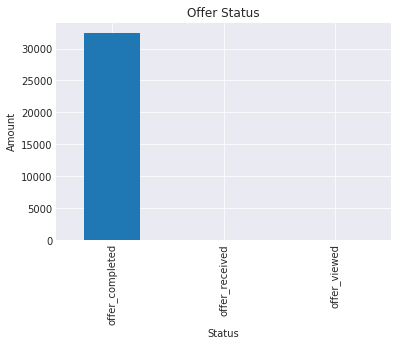

In [45]:
# Analysis by offer status
offerstatus_columns = ['offer_completed', 'offer_received', 'offer_viewed']
offerstatus_dist = df_total[df_total['offer_completed']==1][offerstatus_columns].sum().plot.bar(fontsize=10) 
offerstatus_dist.set_title("Offer Status")
offerstatus_dist.set_xlabel("Status")
offerstatus_dist.set_ylabel("Amount")

#### Findings
1) Most offers are completed by males

2) Most users are that complete offers are in the age of 49-59

3) The average income of useres who complete offers is between 50K-80K

In [46]:
df_total.head()
df_total.columns

Index(['customer_id', 'time', 'offer_id', 'offer_completed', 'offer_received',
       'offer_viewed', 'difficulty', 'duration', 'reward', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational', 'age',
       'became_member_on', 'income', 'year', 'month', 'F', 'M', 'O'],
      dtype='object')

### Prepare df_total for machine learning model

In [47]:
df_total.head()

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed,difficulty,duration,reward,email,...,discount,informational,age,became_member_on,income,year,month,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,5,7,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,5,5,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,5,5,5,1,...,0,0,75,2017-05-09,100000.0,2017,5,1,0,0


In [48]:
# Create bins for age
ages_bins = pd.cut(x=df_total["age"], bins=[18, 20, 25, 29, 35, 39, 49, 59, 69, 79, 89, 99, 102])
    
# Get dummies for age
ages = pd.get_dummies(ages_bins)
    
# Create bins for income
income_bins = pd.cut(x=df_total["income"], bins=[20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000])
    
# Get dummies for age
income = pd.get_dummies(income_bins)
    
# concat original profile df with hot encoded df
df_total1 = pd.concat([df_total, ages, income], axis = 1, sort = False)

# Drop columns age, gender, became_member_on and income
df_total1 = df_total1.drop(['age', 'income', 'became_member_on'], axis=1)

In [49]:
df_total1.head()

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed,difficulty,duration,reward,email,...,"(20000, 30000]","(30000, 40000]","(40000, 50000]","(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]"
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,5,5,5,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,5,5,5,1,...,0,0,0,0,0,0,0,1,0,0


In [50]:
df_total1.isnull().sum()

customer_id         0
time                0
offer_id            0
offer_completed     0
offer_received      0
offer_viewed        0
difficulty          0
duration            0
reward              0
email               0
mobile              0
social              0
web                 0
bogo                0
discount            0
informational       0
year                0
month               0
F                   0
M                   0
O                   0
(18, 20]            0
(20, 25]            0
(25, 29]            0
(29, 35]            0
(35, 39]            0
(39, 49]            0
(49, 59]            0
(59, 69]            0
(69, 79]            0
(79, 89]            0
(89, 99]            0
(99, 102]           0
(20000, 30000]      0
(30000, 40000]      0
(40000, 50000]      0
(50000, 60000]      0
(60000, 70000]      0
(70000, 80000]      0
(80000, 90000]      0
(90000, 100000]     0
(100000, 110000]    0
(110000, 120000]    0
dtype: int64

In [51]:
# Rename Columns
column_names = [ 'customer_id','time','offer_id', 'offer_completed', 'offer_received', 'offer_viewed', 'difficulty','duration','reward','email', 'mobile','social','web','bogo','discount','informational','year','month','F','M','O','18-20','20-25','25-29','29-35','35-39','39-49', '49-59','59-69','69-79','79-89','89-99','99-102','20K-30K', '30K-40K','40K-50K', '50K-60K','60K-70K', '70K-80K','80K-90K','90K-100K', '100K-110K','110K-120K']

In [52]:
df_total1.columns = column_names

In [53]:
df_total1.head()

,customer_id,time,offer_id,offer_completed,offer_received,offer_viewed,difficulty,duration,reward,email,...,20K-30K,30K-40K,40K-50K,50K-60K,60K-70K,70K-80K,80K-90K,90K-100K,100K-110K,110K-120K
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,5,7,5,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,5,5,5,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,5,5,5,1,...,0,0,0,0,0,0,0,1,0,0


In [54]:
df_total1 = df_total1.drop(['year', 'month', 'offer_received', 'offer_viewed', 'informational'], axis = 1)

In [55]:
df_total1.columns

Index(['customer_id', 'time', 'offer_id', 'offer_completed', 'difficulty',
       'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo',
       'discount', 'F', 'M', 'O', '18-20', '20-25', '25-29', '29-35', '35-39',
       '39-49', '49-59', '59-69', '69-79', '79-89', '89-99', '99-102',
       '20K-30K', '30K-40K', '40K-50K', '50K-60K', '60K-70K', '70K-80K',
       '80K-90K', '90K-100K', '100K-110K', '110K-120K'],
      dtype='object')

## 4. Machine Learning Model for order completion prediction

In the following, a Machine Learing Model will be build and evaluated by the Accuracy-Score and the F1-Score.
Justifivation for chosen metrices:
1. Accuracy Score:
The accuracy score is an easy way to identify all the correctly identified positives cases from all poitive cases in the dataset. It consequently gives a fist hint of how good the model is performing. Since all characteristics of the merged data set are regarded as equally important and were not graded during this analysis, it makes sense to use the accuracy score as a metrics.

2. F1-Score:
Even though, the accuracy score gives a first impression of how many positive cases (true positives and true negatives) were identified correctly, it does not analyze the false positives and false negatives. This is why I added the F1-Score as a evaluation metric.  Addtionally, the F1-Score helps to better evaluate imbalanced data sets as it calculates the harmonic mean (such as the dataset provided). Looking at the age and income distribution of data set, which were analyzed in the section above, this might improve the expressiveness of the model evaluation.

In [56]:
# Split data into feature and target
target = df_total1[['offer_completed']]
features = df_total1.drop('offer_completed', axis = 1)

In [57]:
# Change Column order
features = features[['customer_id', 'offer_id', 'time', 'difficulty', 'duration', 'reward',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'F', 'M', 'O',
       '18-20', '20-25', '25-29', '29-35', '35-39', '39-49', '49-59', '59-69',
       '69-79', '79-89', '89-99', '99-102', '20K-30K', '30K-40K', '40K-50K',
       '50K-60K', '60K-70K', '70K-80K', '80K-90K', '90K-100K', '100K-110K',
       '110K-120K']]

In [58]:
features.head()

,customer_id,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,20K-30K,30K-40K,40K-50K,50K-60K,60K-70K,70K-80K,80K-90K,90K-100K,100K-110K,110K-120K
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,6,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,132,5,7,5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,5,5,5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,510,5,5,5,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0


In [59]:
# Normalize numerical features
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

numericals = features.columns[2:6]

features_minmax = pd.DataFrame(data = features)
features_minmax[numericals] = scaler.fit_transform(features[numericals])
features_minmax.head(3)

,customer_id,offer_id,time,difficulty,duration,reward,email,mobile,social,web,...,20K-30K,30K-40K,40K-50K,50K-60K,60K-70K,70K-80K,80K-90K,90K-100K,100K-110K,110K-120K
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.000000,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.008403,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.184874,0.25,0.571429,0.5,1,1,0,1,...,0,0,0,0,0,0,0,1,0,0


In [60]:
# Drop person and offer_id
features = features_minmax[features_minmax.columns[2:]]
features.head()

,time,difficulty,duration,reward,email,mobile,social,web,bogo,discount,...,20K-30K,30K-40K,40K-50K,50K-60K,60K-70K,70K-80K,80K-90K,90K-100K,100K-110K,110K-120K
0,0.000000,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.008403,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.184874,0.25,0.571429,0.5,1,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.705882,0.25,0.285714,0.5,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0.714286,0.25,0.285714,0.5,1,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [61]:
target.head()

,offer_completed
0,0
1,0
2,1
3,0
4,1


### Creat train and test set

In [62]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=0.3, random_state=42)

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

### Evaluate naive predictor and use as benchmark

In [110]:
# Use Naive predictior as a benachmark
#https://uc-r.github.io/ts_benchmarking#naive
#https://www.programcreek.com/python/example/84417/sklearn.metrics.accuracy_score

accuracy = accuracy_score(y_train, np.ones(len(y_train)))
f1 = f1_score(y_train, np.ones(len(y_train)))

print((np_accuracy))
print((np_f1score))

0.219022109578
0.359340667995


### Random Forest Classifier

A Random Forest is a classification and regression method that consists of multiple uncorrelated decision trees. All decision trees are grown under a certain type of randomization during the learning process. For a classification, each tree in this forest is allowed to make a decision and the class with the most votes decides the final classification.

https://de.wikipedia.org/wiki/Random_Forest

I decided to use the random forest classifier to analyze this problem is, that it can be used to quickly identify of significant information from vast datasets. It relies on collecting various decision trees to arrive at any solution. The random forest classifier has several apsects that makes it a good solutuin for this project. It is robst to ouliers and works well with non-linear data. There is a low risk of overitting and it runs effiviently on large datasets.

https://towardsai.net/p/machine-learning/why-choose-random-forest-and-not-decision-trees

In [64]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
scorer = make_scorer(fbeta_score, beta=0.5)
# instantiate a random forest classifier obj
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees
n_estimators = [10, 50, 100, 120, 150, 200, 250]

# Number of features
max_features = ['auto']

# Minimum number of samples
min_samples_split = [2, 5,7, 10]

# Minimum number of samples at each leaf
min_samples_leaf = [1, 3, 5, 7]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 60,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 4)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=3, max_features=auto 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=3, max_features=auto 
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=3, max_features=auto 
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=auto 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=auto, total=  38.4s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=auto 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=auto, total=  36.7s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_features=auto 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=3, max_features=auto, total= 1.4min
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=auto 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=3

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.7min


[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=3, max_features=auto, total= 1.6min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=auto 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=auto, total= 1.2min
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=auto 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=3, max_features=auto, total= 1.7min
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=7, max_features=auto 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=3, max_features=auto, total= 1.7min
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=7, max_features=auto 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=auto, total= 1.2min
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=7, max_features=auto 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=auto, total= 1

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 35.8min


[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=5, max_features=auto, total=  56.6s
[CV] n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=5, max_features=auto, total=  55.9s
[CV] n_estimators=200, min_samples_split=7, min_samples_leaf=1, max_features=auto 
[CV]  n_estimators=200, min_samples_split=7, min_samples_leaf=1, max_features=auto, total= 1.5min
[CV] n_estimators=200, min_samples_split=7, min_samples_leaf=1, max_features=auto 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, total= 1.7min
[CV] n_estimators=200, min_samples_split=7, min_samples_leaf=1, max_features=auto 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, total= 1.7min
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=7, max_features=auto 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=1, max_features=auto, total= 

[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 42.8min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=60, n_jobs=4,
          param_distributions={'n_estimators': [10, 50, 100, 120, 150, 200, 250], 'max_features': ['auto'], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [104]:
def performance(clf, X_train, y_train):
    class_name = re.sub("", '', str(clf.__class__))


    rf_pred = clf.predict(X_train)

    acc = accuracy_score(y_train, rf_pred)
    f1 = f1_score(y_train, rf_pred)
    
    print((class_name, acc))
    print((class_name, f1))
    
    return acc, f1

In [105]:
# evaluate random forest performance
performance(rf_random.best_estimator_, X_train, y_train)

("<class 'sklearn.ensemble.forest.RandomForestClassifier'>", 0.91120647446790126)
("<class 'sklearn.ensemble.forest.RandomForestClassifier'>", 0.78040789192525928)


(0.91120647446790126, 0.78040789192525928)

In [106]:
# evaluate random forest performance
performance(rf_random.best_estimator_, X_test, y_test)

("<class 'sklearn.ensemble.forest.RandomForestClassifier'>", 0.78983916491196626)
("<class 'sklearn.ensemble.forest.RandomForestClassifier'>", 0.45300839552238803)


(0.78983916491196626, 0.45300839552238803)

In [107]:
print (rf_random.best_params_)

{'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto'}


## 5. Conclusion

The overall aim in this project was to build and tune a machine learning model, that prdicts if a customer would response to an offer or not. Herefore, three datasets were provided. I appproached the issue in several steps: First I gained a general understanding of the data sets by analyzing the provided data sets. The Data Understanding section (1) served to understand and get to know the provided data. Second, I cleaned and combined the data sets as basis for a machine learing model (2).  In order to prepare and clean the data, categorical variables were replaced by dummy variables, numercial features were normalized, NaNs were eliminated and the offer_id was be cleaned (transcipt data set) in order to identify a key value to merge the data frames. Once all data was cleaned, the data sets were combined. As a consequence, each row of the new data set provided information of an individual, the related customer and whether or not the offer was successful or not.

Finally, a machine learning model was build and tuned (4). The model predicts if a customer will respond to an offer or not. As a benchmark, I used a naive predictor. To better understand how well the model performs, I decided to process the accuracy score and the F1 score. The accuracy score is one of the easiest ways to generate a performance metric. The accurancy score shows the proportion of right predictions. However, the accuracy score needs to have two equal groups of true and falses in order to provided good results. Therefore, I also analyzed the F1-Schore which interprets a weighted average of the precision and recall. The F1 score reaches its best value at 1 and worst score at 0.

In the following the results of the naive prdictor model and the (tuned) random forest model is shwon:

Naive predictor accuracy: 0.219
Naive predictor f1-score: 0.359

RandomForestClassifier model accuracy (Training Set): 0.91
RandomForestClassifier model f1-score (Training Set): 0.78

RandomForestClassifier model accuracy (Test Set): 0.79
RandomForestClassifier model f1-score (Test Set): 0.45

For the training set, the RandomForestClassifier achieved an accuracy score of 0.91 and an F1-Score of 0.78. This means that 91% of the true positives and true negatives were identified correctly. Furthermore, the F1-Score shows that the model performed with an accuracy of 78% including the false positives and false negatives.

For the test set, the RandomForestClassifier achieved an accuracy score of 0.79 and an F1-Score of 0.45. This means that 79% of the true positives and true negatives were identified correctly. Furthermore, the F1-Score shows that the model performed with an accuracy of 45% including the false positives and false negatives.

The results show, that the RandomForestClassifier performs better than the naive predictor. However, with results in the test set of 79% accuracy and 45% F1-Score there is still potential for improvements. Never the less, the result shows that the constructed model did not overfit the training data. The main issue of building and tuning the model was the tradeoff between the accuracy of the results and time of running the tuning porcess.

Possible Improvements:

Compared to the naive predictor, an improvement by using the RandomForestClassifier can be clearly seen. There are some advantages using the naive predictor: on the one hand it works great for data sets with multiple classes, espacially for text classification. Additionally, less training data is needed and the algorithm runs quicker than discriminative models. However, the model size of the naive predictor is compared to the RandomForestClassifier low and quite constant. Thus, it is not surprising that for the data provided, RandomForestClassifier performs better than the naive prediction. 
There are some options to further improve the RandomForestClassifier results. First, the more data is gathered the better the results of the model. Also creating new and dependend features (e.g. a function of diffuculty and reward) might help the algorithm to costruct better decision boundries. Seconond, further parameter tuning would be necessary for a better performance of the model. Finally, more detaillied information about the customers using the Starbucks App (place of residence, more detailed infomation to an individual,…) could help to imporove the classification results.